<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/09_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de un modelo LSTM

#### **Importación de Datos**

In [ ]:
!pip install pytorch-forecasting==1.4.0 pytorch-lightning==2.4.0 torchmetrics==1.3.1 ucimlrepo

In [ ]:
import requests
import pandas as pd
import numpy as np
import sys, os, math, typing as t
import warnings

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import pytorch_lightning as pl

from datetime import timedelta
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import LightningModule

from io import BytesIO
from dataclasses import dataclass


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 47.6 MB/s eta 0:00:00


In [ ]:
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True
})

warnings.filterwarnings('ignore')

In [ ]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/enriched_zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# df = df.set_index("datetime") Esto ya no se hace

t0 = df["datetime"].min()
df["time_idx"] = ((df["datetime"] - t0) / pd.Timedelta(minutes=10)).astype(int)

# 4. Validación de columnas mínimas
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                     f"Columnas disponibles: {df.columns.tolist()}")

# 5. Features de calendario
df["day_of_week"] = df["datetime"].dt.dayofweek

print(df.head())

             datetime  temperature  humidity  wind_speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   general_diffuse_flows       zone_1  is_weekend  is_holiday  hour  day  \
0                  0.051  34055.69620        True        True     0    1   
1                  0.070  29814.68354        True        True     0    1   
2                  0.062  29128.10127        True        True     0    1   
3                  0.091  28228.86076        True        True     0    1   
4                  0.048  27335.69620        True        True     0    1   

   month  time_idx  day_of_week  
0      1         0            6  
1      1         1            6  
2      1         2            6  
3      1         3            6  
4      1    

#### **Definición de Funciones y Partición de los datos**

In [ ]:
prediction_length = 24 * 6        # 24 horas * 6 (10-min steps) = 144
max_encoder_length = 7 * 24 * 6   # 7 días históricos (~1008) — ajustar si memoria se agota

# crear columna "group", es constante, porque solo tenemos zone_1
df['zone'] = 'zone_1'

training_cutoff = df['time_idx'].max() - prediction_length

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="zone_1",
    group_ids=["zone"], #No tenemos esto realmente, todas son "zone_1"

    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length,

    static_categoricals=["zone"], #No estoy segura de esto, si de pronto integrar las otras zonas-
    time_varying_known_reals=["time_idx", "hour", "day", "day_of_week", "month", "is_weekend", "is_holiday", "temperature", "humidity", "wind_speed", "general_diffuse_flows"],
    time_varying_unknown_reals=["zone_1"],

    target_normalizer=GroupNormalizer(groups=["zone"]),

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# validación (reutiliza normalizadores del training)
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=64*4, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### **Entrenamiento**

In [ ]:
class TFTLightningWrapper(LightningModule):
    def __init__(self, tft):
        super().__init__()
        self.tft = tft
        self.loss = tft.loss
        self.save_hyperparameters(ignore=["tft","loss"])

    def forward(self, x):
        return self.tft(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss(out[0], y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss(out[0], y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return self.tft.configure_optimizers()


In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, Callback

class CheckDeviceCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print(f"\nEntrenando en dispositivo: {next(pl_module.parameters()).device}\n")

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="tft-{epoch:02d}-{val_loss:.4f}")
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[early_stop, checkpoint, lr_monitor, CheckDeviceCallback()],
    gradient_clip_val=0.1,
    log_every_n_steps=10
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
)

if torch.cuda.is_available():
    tft = tft.to("cuda")

tft_module = TFTLightningWrapper(tft)
tft_module = tft_module.to("cuda" if torch.cuda.is_available() else "cpu")

trainer.fit(tft_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
# el mejor checkpoint queda guardado en checkpoint.best_model_path


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                      | Params | Mode 
-----------------------------------------------------------
0 | tft  | TemporalFusionTransformer | 408 K  | train
1 | loss | QuantileLoss              | 0      | train
-----------------------------------------------------------
408 K     Trainable params
0         Non-trainable params
408 K     Total params
1.633     Total estimated model params size (MB)
575       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Entrenando en dispositivo: cuda:0



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

---

In [ ]:
# Guarda el estado del modelo entrenado
torch.save(tft.state_dict(), "tft_model_state_dict.pt")

print("Estado del modelo guardado exitosamente en tft_model_state_dict.pt")

Estado del modelo guardado exitosamente en tft_model_state_dict.pt


## Checkpoint:

In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
)


tft.load_state_dict(torch.load("tft_model_state_dict.pt", map_location="cuda" if torch.cuda.is_available() else "cpu"))

tft.eval()  # poner en modo evaluación
print("✅ Modelo TFT cargado correctamente desde tft_model_state_dict.pt")

✅ Modelo TFT cargado correctamente desde tft_model_state_dict.pt


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


#### **Predicción**

In [ ]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True) #Sería tft_module.tft.predict si lo hicieramos sin el checkpoint


quantiles = list(tft.loss.quantiles)
median_idx = quantiles.index(0.5) if 0.5 in quantiles else len(quantiles)//2

# extraer mediana de predicción (shape: n_samples, prediction_length)
y_pred = raw_predictions.output[0][:, :, median_idx].cpu().numpy()

# Construir y_true (agregando batches)
y_true_list = []
for x_batch, y_batch in val_dataloader:
    # y_batch[0] contiene target según la estructura típica de pytorch-forecasting
    y_true_list.append(y_batch[0].cpu().numpy())

y_true = np.concatenate(y_true_list, axis=0)  # shape: (n_samples, prediction_length)


# aplanar para métricas comparables
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
non_zero_mask = y_true_flat != 0
mape = np.mean(np.abs((y_true_flat[non_zero_mask] - y_pred_flat[non_zero_mask]) / y_true_flat[non_zero_mask]))*100

print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}%")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number o

MAE: 552.396 | RMSE: 644.572 | MAPE: 2.12%


## INTERPRETABILIDAD:

attention torch.Size([1008])
static_variables torch.Size([4])
encoder_variables torch.Size([13])
decoder_variables torch.Size([12])
encoder_length_histogram torch.Size([1009])
decoder_length_histogram torch.Size([144])


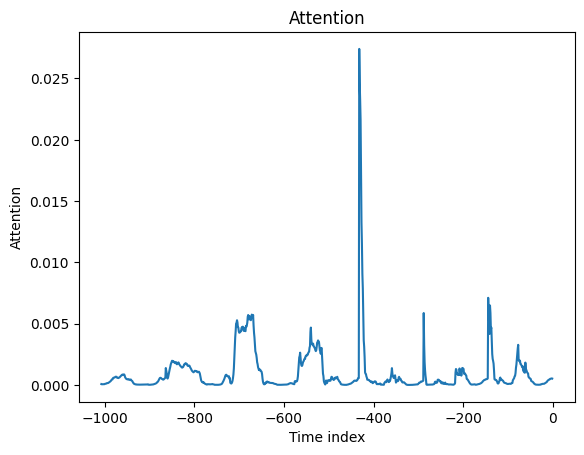

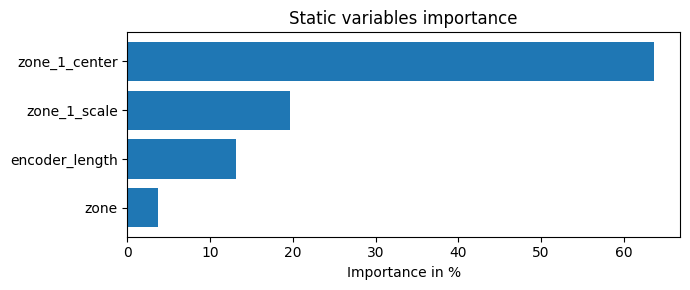

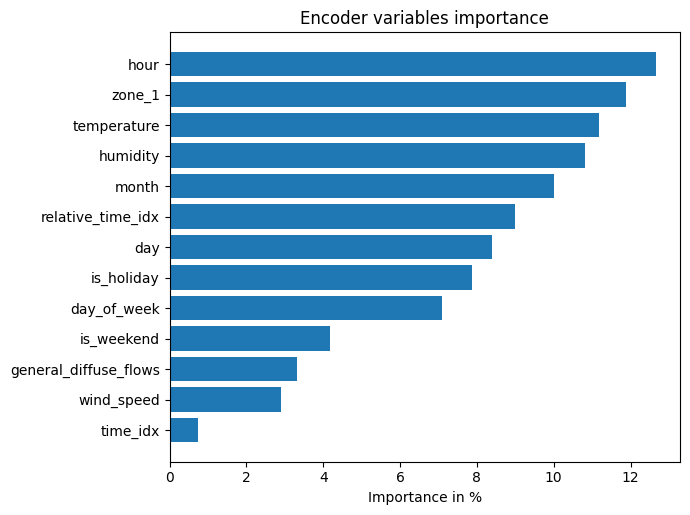

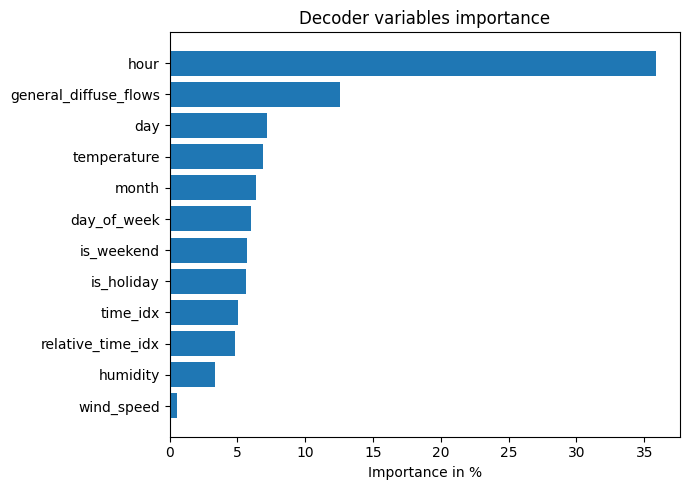

In [ ]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
figs = tft.plot_interpretation(interpretation)

# Para inspección programática: ver las claves y shapes
for k, v in interpretation.items():
    print(k, getattr(v, "shape", None))

## PRONÓSTICO:

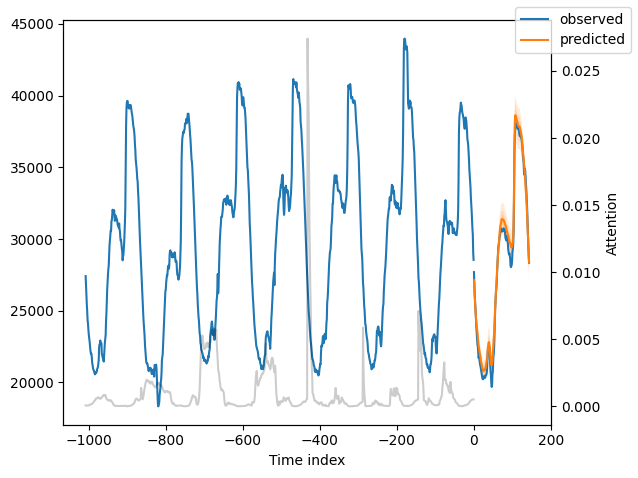

In [ ]:
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0)
plt.show()


In [ ]:
print("Cuantiles:", quantiles)

Cuantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


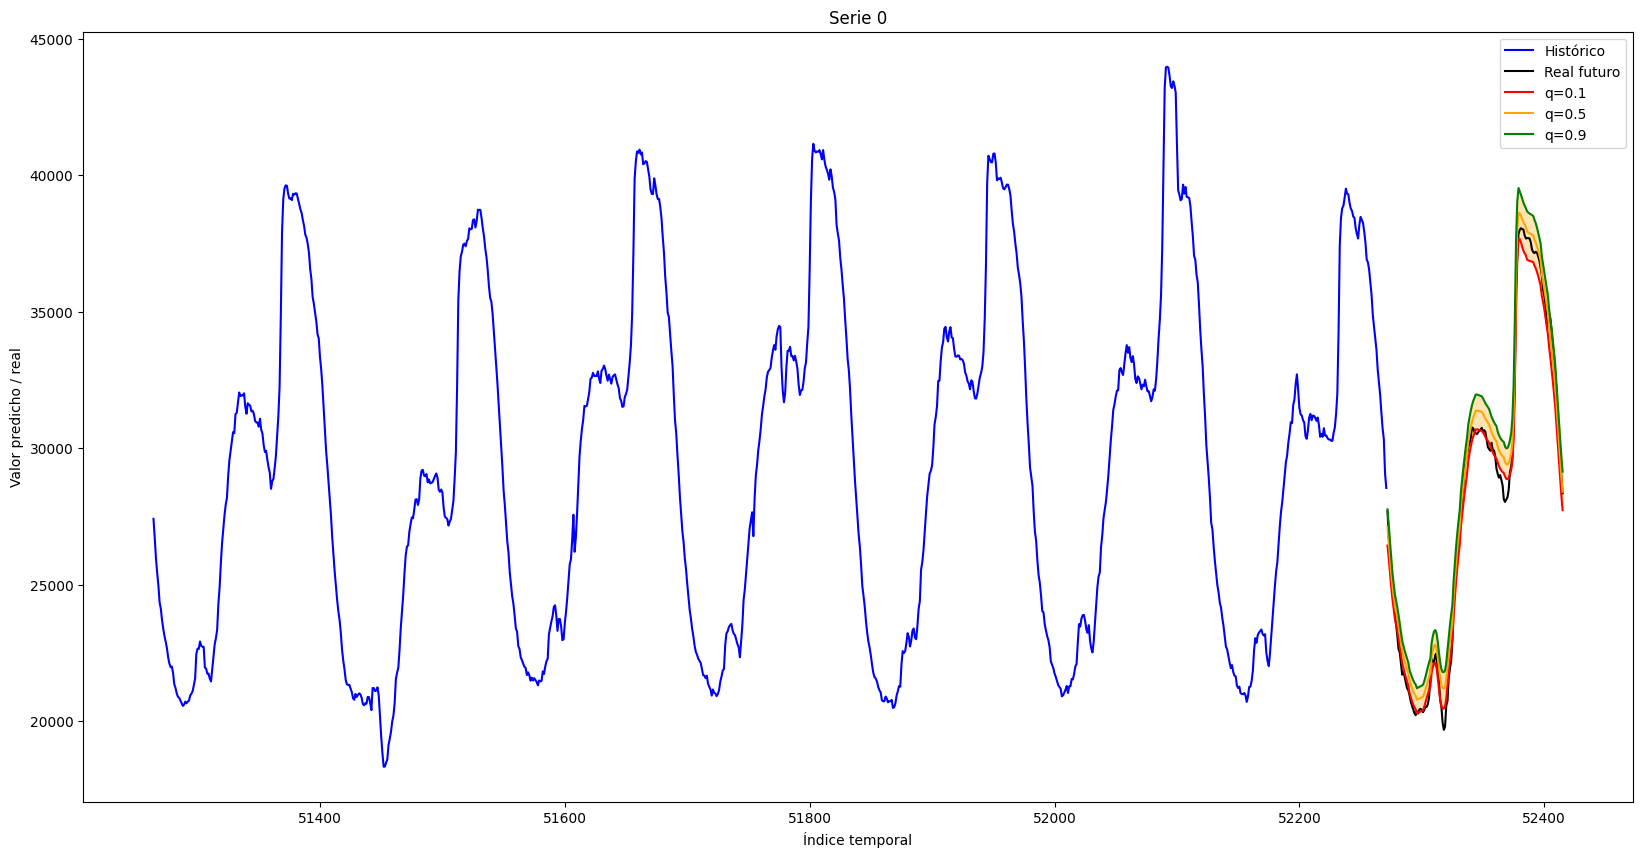

In [ ]:
num_series = len(x["decoder_target"])

for i in range(num_series):  # se ajusta al batch real
    plt.figure(figsize=(20, 10))


    encoder_target = x["encoder_target"][i].cpu().numpy().flatten()
    decoder_target = x["decoder_target"][i].cpu().numpy().flatten()


    decoder_time = x["decoder_time_idx"][i].cpu().numpy().flatten()
    encoder_time = np.arange(decoder_time[0] - len(encoder_target), decoder_time[0])


    preds = raw_predictions.output[i]
    preds = preds.cpu().numpy()
    preds = np.squeeze(preds)


    sns.lineplot(x=encoder_time, y=encoder_target, label="Histórico", color="blue")


    sns.lineplot(x=decoder_time, y=decoder_target, label="Real futuro", color="black")


    colores = ["red", "orange", "green"]
    for q, c in zip([0.1, 0.5, 0.9], colores):
        if q in quantiles:
            q_idx = quantiles.index(q)
            sns.lineplot(x=decoder_time, y=preds[:, q_idx].flatten(), label=f"q={q}", color=c)


    if 0.1 in quantiles and 0.9 in quantiles:
        q10_idx = quantiles.index(0.1)
        q90_idx = quantiles.index(0.9)
        plt.fill_between(decoder_time,
                         preds[:, q10_idx].flatten(),
                         preds[:, q90_idx].flatten(),
                         alpha=0.3,
                         color="orange")

    plt.title(f"Serie {i}")
    plt.xlabel("Índice temporal")
    plt.ylabel("Valor predicho / real")
    plt.legend()
    plt.show()

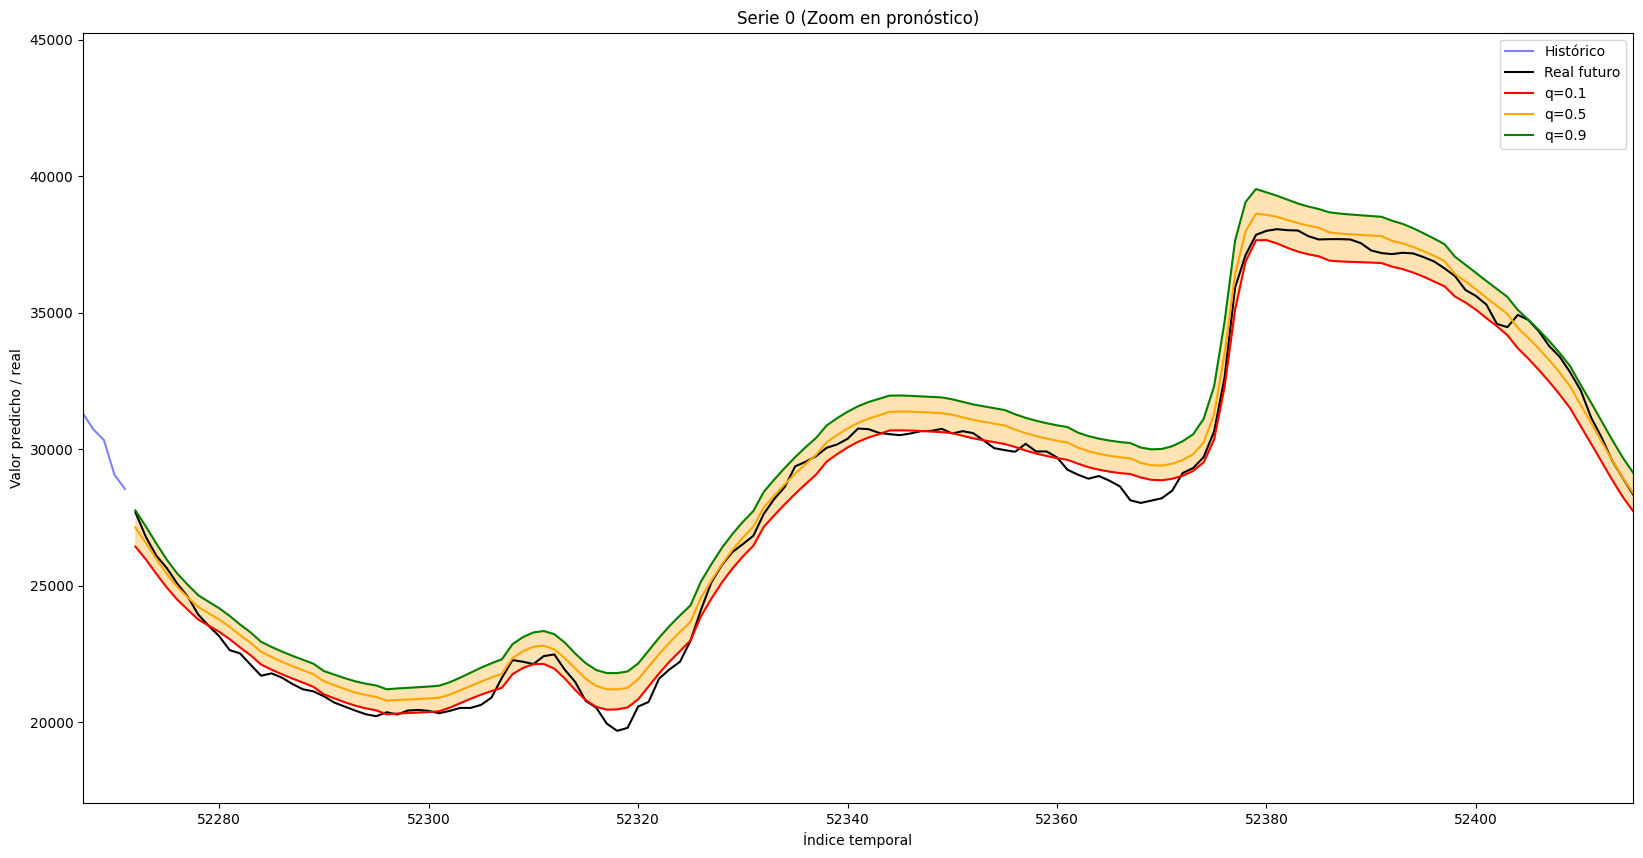

In [ ]:
for i in range(num_series):
    plt.figure(figsize=(20, 10))


    encoder_target = x["encoder_target"][i].cpu().numpy().flatten()
    decoder_target = x["decoder_target"][i].cpu().numpy().flatten()

    decoder_time = x["decoder_time_idx"][i].cpu().numpy().flatten()
    encoder_time = np.arange(decoder_time[0] - len(encoder_target), decoder_time[0])

    preds = raw_predictions.output[i]
    preds = preds.cpu().numpy()
    preds = np.squeeze(preds)

    sns.lineplot(x=encoder_time, y=encoder_target, label="Histórico", color="blue", alpha=0.5)
    sns.lineplot(x=decoder_time, y=decoder_target, label="Real futuro", color="black")

    colores = ["red", "orange", "green"]
    for q, c in zip([0.1, 0.5, 0.9], colores):
        if q in quantiles:
            q_idx = quantiles.index(q)
            sns.lineplot(x=decoder_time, y=preds[:, q_idx].flatten(), label=f"q={q}", color=c)


    if 0.1 in quantiles and 0.9 in quantiles:
        q10_idx = quantiles.index(0.1)
        q90_idx = quantiles.index(0.9)
        plt.fill_between(decoder_time,
                         preds[:, q10_idx].flatten(),
                         preds[:, q90_idx].flatten(),
                         alpha=0.3,
                         color="orange")

    plt.title(f"Serie {i} (Zoom en pronóstico)")
    plt.xlabel("Índice temporal")
    plt.ylabel("Valor predicho / real")
    plt.legend()

    plt.xlim(decoder_time[0] - 5, decoder_time[-1])

    plt.show()